In [10]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
time1 = time()

In [11]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [12]:

trainset = datasets.ImageFolder('cifar/train', transform=transform)
valset = datasets.ImageFolder('cifar/test', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [13]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Classes :  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog']


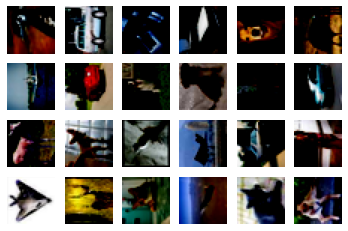

In [14]:
figure = plt.figure()
num_of_images = 24
for index in range(1, num_of_images + 1):
    plt.subplot(4, 6, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().T.squeeze())
class_list = trainset.classes
print('Classes : ', class_list)

In [15]:
input_size = 3072
hidden_sizes = [2048, 1024, 512, 256]
output_size = len(class_list)

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                            nn.ReLU(),
                            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                            nn.ReLU(),
                            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                            nn.ReLU(),
                            nn.Linear(hidden_sizes[2], hidden_sizes[3]),
                            nn.ReLU(),
                            nn.Linear(hidden_sizes[3], output_size),
                            nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=3072, out_features=2048, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2048, out_features=1024, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=256, bias=True)
  (7): ReLU()
  (8): Linear(in_features=256, out_features=6, bias=True)
  (9): LogSoftmax(dim=1)
)


In [16]:

images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities

criterion = nn.NLLLoss()

#tlabls = labelTransform(labels,10)
loss = criterion(logps,labels) #calculate the loss


In [17]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-8.6803e-06, -8.2660e-06, -3.4688e-06,  ..., -5.0385e-05,
         -5.5782e-05, -5.7606e-05],
        [ 2.2500e-06,  2.1486e-06,  4.1641e-06,  ...,  4.3672e-05,
          4.6734e-05,  4.9911e-05],
        [ 7.1313e-06,  3.9895e-06,  2.5852e-05,  ..., -1.1231e-04,
         -1.1744e-04, -1.3962e-04],
        ...,
        [ 4.8833e-05,  5.7920e-05,  5.6859e-05,  ...,  1.9048e-05,
          1.6010e-05,  2.8479e-05],
        [ 4.8641e-06,  8.5035e-06,  2.1166e-05,  ..., -1.7347e-05,
         -1.1662e-05, -2.1568e-05],
        [-4.1583e-05, -4.7298e-05, -3.6636e-05,  ..., -3.3194e-05,
         -3.0855e-05, -3.8324e-05]])


In [18]:
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
time0 = time()
epochs = 30
for e in range(epochs):
    running_loss = 0
    cnt=0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        cnt+=images.shape[0]
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {} no of images {}".format(e, running_loss/len(trainloader),cnt))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 1.7613888056293479 no of images 30000
Epoch 1 - Training loss: 1.4961899513883123 no of images 30000
Epoch 2 - Training loss: 1.277058389268196 no of images 30000
Epoch 3 - Training loss: 1.1770377222663049 no of images 30000
Epoch 4 - Training loss: 1.11188013047806 no of images 30000
Epoch 5 - Training loss: 1.0522202916745185 no of images 30000
Epoch 6 - Training loss: 0.9976893884540875 no of images 30000
Epoch 7 - Training loss: 0.9464616090504091 no of images 30000
Epoch 8 - Training loss: 0.9013631914470241 no of images 30000
Epoch 9 - Training loss: 0.8606858064116699 no of images 30000
Epoch 10 - Training loss: 0.8113671711512974 no of images 30000
Epoch 11 - Training loss: 0.762710150053252 no of images 30000
Epoch 12 - Training loss: 0.7189865768082869 no of images 30000
Epoch 13 - Training loss: 0.6781249507022565 no of images 30000
Epoch 14 - Training loss: 0.6282224765083174 no of images 30000
Epoch 15 - Training loss: 0.5898077303666804 no of ima

In [19]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 32, 32).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(len(class_list)), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(class_list)))
    ax2.set_yticklabels(class_list)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Class = cat


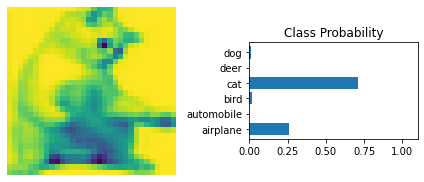

In [20]:
images, labels = next(iter(valloader))

img = images[0].view(1, input_size)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Class =", class_list[probab.index(max(probab))])
view_classify(img.view(3, 32, 32), ps)

In [21]:
correct_count, all_count = 0, 0
pred_label_arr = [[],[]]
true_label_arr =[[],[]]
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 3072)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img)

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1
    pred_label_arr[0].append(pred_label)
    true_label_arr[0].append(true_label)
print("Number Of Images Tested =", all_count)
print("\nModel Test Accuracy =", (correct_count/all_count))
images,labels = iter(trainloader).next()
for i in range(len(labels)):
  img = images[i].view(1, 3072)
  # Turn off gradients to speed up this part
  with torch.no_grad():
      logps = model(img)

  # Output of the network are log-probabilities, need to take exponential for probabilities
  ps = torch.exp(logps)
  probab = list(ps.numpy()[0])
  pred_label = probab.index(max(probab))
  true_label = labels.numpy()[i]
  if(true_label == pred_label):
    correct_count += 1
  all_count += 1
  pred_label_arr[1].append(pred_label)
  true_label_arr[1].append(true_label)
print("Number Of Images Tested =", all_count)
print("\nModel Train Accuracy =", (correct_count/all_count))

Number Of Images Tested = 6000

Model Test Accuracy = 0.6071666666666666
Number Of Images Tested = 6064

Model Train Accuracy = 0.6111477572559367


In [22]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'axes.facecolor': 'lightblue', 'figure.facecolor': 'lightblue'})

def confusionMatrixAndAccuracyReport(Y_test, Y_pred):
    cm = metrics.confusion_matrix(Y_test, Y_pred)
    overallAccuracy = np.trace(cm)/sum(cm.flatten())

    classwiseAccuracy = np.zeros(len(cm))
    for n in range(len(cm)):
        for i in range(len(cm)):
            for j in range(len(cm)):
                if (i != n and j != n) or (i == n and j == n):
                    classwiseAccuracy[n] += cm[i][j]

    classwiseAccuracy /= sum(cm.flatten())

    plt.figure(figsize=(10,10))
    plt.title('Accuracy Score: {0:3.3f}'.format(overallAccuracy), size=12)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    sns.heatmap(data=cm, annot=True, square=True,  cmap='Blues', fmt='g')

    plt.show()
    print('Overall Accuracy Score: {0:3.3f}'.format(overallAccuracy))
    print('Classwise Accuracy Score: {0}'.format(classwiseAccuracy))


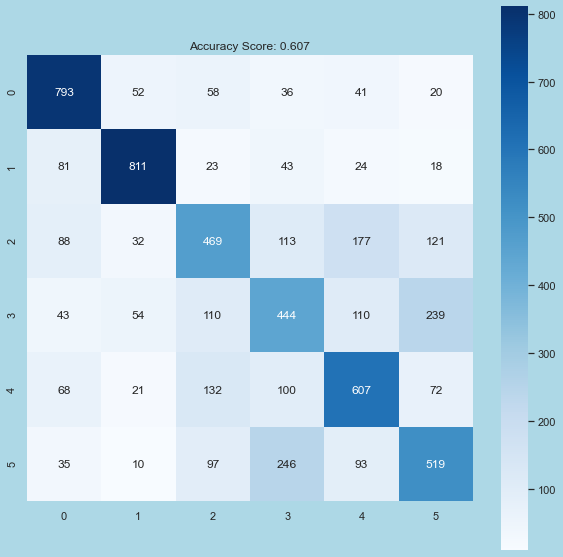

Overall Accuracy Score: 0.607
Classwise Accuracy Score: [0.913      0.94033333 0.8415     0.81766667 0.86033333 0.8415    ]


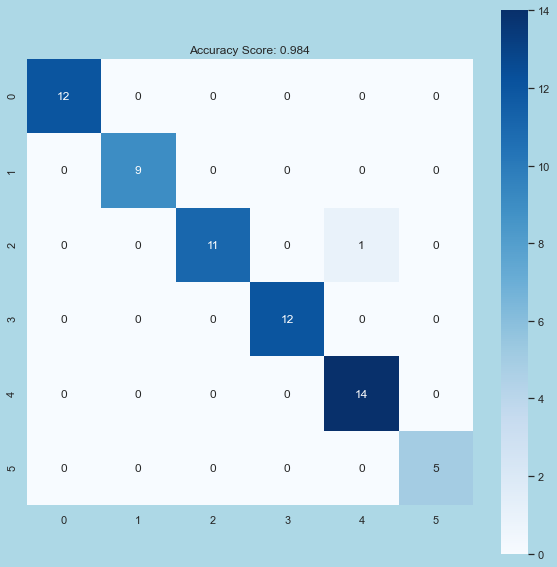

Overall Accuracy Score: 0.984
Classwise Accuracy Score: [1.       1.       0.984375 1.       0.984375 1.      ]

All done (in minutes) = 37.91865974664688


In [23]:

confusionMatrixAndAccuracyReport(true_label_arr[0],pred_label_arr[0])
confusionMatrixAndAccuracyReport(true_label_arr[1],pred_label_arr[1])
print("\nAll done (in minutes) =",(time()-time1)/60)